In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
local_dir = 's18-transformer-speeding-up-strategy'
repo_url = 'https://github.com/aakashvardhan/s18-transformer-speeding-up-strategy.git'

# Check if the local directory already exists
if not os.path.exists(local_dir):
    # Clone the repository because it does not exist
    !git clone --quiet {repo_url}
else:
    # Change directory to the local repository
    %cd {local_dir}
    # Pull the latest changes because the repository already exists
    !git pull

In [3]:
import sys
sys.path.append('/content/s18-transformer-speeding-up-strategy')

In [4]:
!pip install -q -r /content/s18-transformer-speeding-up-strategy/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.9 MB/s eta 0:00:00


In [5]:
%cd /content/s18-transformer-speeding-up-strategy

/content/s18-transformer-speeding-up-strategy


In [6]:
import os
import warnings
import random

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.text import BLEUScore, CharErrorRate, WordErrorRate

import lightning as L
from lightning.pytorch.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
    TQDMProgressBar,
)
from lightning.pytorch.loggers import TensorBoardLogger

from config_file import get_config, get_weights_file_path
from dataset import LiTDataModule
from utils import get_model, greedy_decode

In [7]:
cfg = get_config()
# cfg['batch_size'] = 24
cfg['num_epochs'] = 18

In [8]:
# Define the directory name
directory_name = "weights"

# Create the directory if it does not exist
if not os.path.exists(directory_name):
  os.makedirs(directory_name)
  print(f"Directory '{directory_name}' created!")
else:
  print(f"Directory '{directory_name}' already exists.")

Directory 'weights' created!


In [9]:
# Clear CUDA cache and set seed
torch.cuda.empty_cache()
L.seed_everything(42, workers=True)
print("Seed set to 42...")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Seed set to 42...


In [10]:
# Initialize the data module
datamodule = LiTDataModule(cfg)
datamodule.setup()
print("DataModule initialized...")
tokenizer_src, tokenizer_tgt = datamodule.tokenizer_src, datamodule.tokenizer_tgt
train_dataloader = datamodule.train_dataloader()
# Initialize TensorBoard logger
tb_logger = TensorBoardLogger(
    save_dir=os.getcwd(), version=1, name="lightning_logs"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/32332 [00:00<?, ? examples/s]

Max length of the source sentence : 43
Max length of the source target : 38
DataModule initialized...


In [11]:
# Initialize the trainer
trainer = L.Trainer(
            precision=cfg["precision"],
            max_epochs=cfg["num_epochs"],
            logger=tb_logger,
            accelerator=cfg["accelerator"],
            devices="auto",
            default_root_dir=cfg["model_folder"],
            callbacks=[
                ModelCheckpoint(
                    dirpath=cfg["model_folder"],
                    save_top_k=3,
                    monitor="train_loss_step",
                    mode="min",
                    filename="model-{epoch:02d}-{train_loss:.4f}",
                    save_last=True,
                ),
                LearningRateMonitor(logging_interval="step", log_momentum=True),
                EarlyStopping(
                    monitor="train_loss_step", mode="min", stopping_threshold=1.6
                ),
                TQDMProgressBar(refresh_rate=10),
            ],
            gradient_clip_val=0.5,
            num_sanity_val_steps=5,
            enable_progress_bar=True,
            check_val_every_n_epoch=1,
            limit_val_batches=2)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [12]:
from main import LTModel
# Initialize the model
model = LTModel(cfg, tokenizer_src=tokenizer_src, tokenizer_tgt=tokenizer_tgt, train_dataloader=train_dataloader)
print("Model initialized...")

Model initialized...


In [13]:
print(cfg["one_cycle_best_lr"])

0.0001


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:44: Attribute 'train_dataloader' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['train_dataloader'])`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Max length of the source sentence : 43
Max length of the source target : 38


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


--------------------------------------------------------------------------------
    SOURCE: 'I don't understand...' said he.
    TARGET: — Non capisco — disse lui.
 PREDICTED: lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasc

Finding best initial lr:   0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
INFO: `Trainer.fit` stopped: `max_steps=18` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=18` reached.
INFO: Learning rate set to 0.000774263682681127
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.000774263682681127
INFO: Restoring states from the checkpoint path at weights/.lr_find_d9153072-5c19-43a3-98b5-8bb381ad99ca.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at weights/.lr_find_d9153072-5c19-43a3-98b5-8bb381ad99ca.ckpt
INFO: Restored all states from the checkpoint at weights/.lr_find_d9153072-5c19-43a3-98b5-8bb381ad99ca.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at weights/.lr_find_d9153072-5c1

Suggested learning rate: 0.000774263682681127


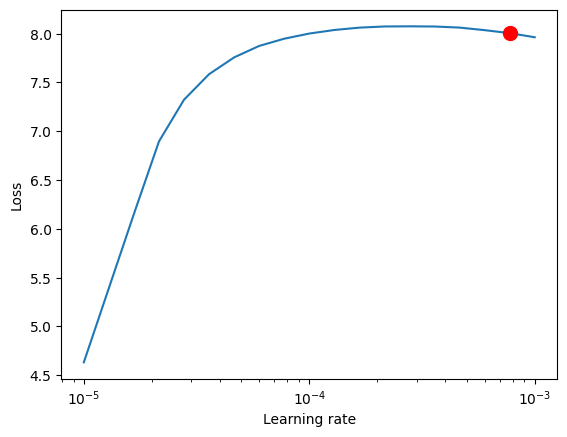

In [14]:
 # Learning rate finder
tuner = L.pytorch.tuner.Tuner(trainer)
lr_finder = tuner.lr_find(
    model, datamodule=datamodule, num_training=trainer.max_epochs, min_lr=1e-5, max_lr=1e-3
)
print(lr_finder)

# Initialize suggested_lr with a default value
suggested_lr = model.one_cycle_best_lr

if lr_finder:
  fig = lr_finder.plot(suggest=True)
  fig.show()
  suggested_lr = lr_finder.suggestion()
  print(f"Suggested learning rate: {suggested_lr}")
else:
  print("Learning rate finding did not complete successfully.")

# Set the best learning rate
model.one_cycle_best_lr = suggested_lr

In [15]:
print(model.one_cycle_best_lr)

0.000774263682681127


In [16]:
trainer.fit(model=model, datamodule=datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Transformer      | 34.9 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
34.9 M    Trainable params
0         Non-trainable params
34.9 M    Total params
139.716   Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Transformer      | 34.9 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
34.9 M    Trainable params
0         Non-trainable params
34.9 M    Total params
139.716   Total estimated model params size (MB)


Max length of the source sentence : 43
Max length of the source target : 38


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: 'I don't understand...' said he.
    TARGET: — Non capisco — disse lui.
 PREDICTED: lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasc

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 52. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: And he loves me; All this has been, but will pass,' she said, feeling that tears of joy at this return to life were running down her cheeks.
    TARGET: Perché lui mi ama! Questo è stato e passerà” ella diceva, sentendo che le lacrime della gioia del ritorno alla vita le scorrevano per le guance.
 PREDICTED: — Non , ma , ma , ma , ma , ma , e , , .
--------------------------------------------------------------------------------
    SOURCE: 'I don't understand...' said he.
    TARGET: — Non capisco — disse lui.
 PREDICTED: lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava l

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: "Mr. Rivers! you quite put me out of patience: I am rational enough; it is you who misunderstand, or rather who affect to misunderstand."
    TARGET: — Signor Rivers, mi farete perder la pazienza; sono calma; siete voi che non capite, o che fingete di non capirmi.
 PREDICTED: — Non , , — disse , ma , , , , , .
--------------------------------------------------------------------------------
    SOURCE: I contended with my inward dimness of vision, before which clouds yet rolled.
    TARGET: Alcune nubi mi offuscavano la vista e mi sforzavo di dissiparle.
 PREDICTED: trecciolina trecciolina lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasci

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: One has to take a decision,' he said. 'Anything would be better than the condition in which you are living.
    TARGET: Bisogna decidersi — egli disse. — Qualunque cosa è migliore della posizione in cui vivi.
 PREDICTED: trecciolina trecciolina trecciolina trecciolina lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: 'I don't understand...' said he.
    TARGET: — Non capisco — disse lui.
 PREDICTED: lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasc

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: And he loves me; All this has been, but will pass,' she said, feeling that tears of joy at this return to life were running down her cheeks.
    TARGET: Perché lui mi ama! Questo è stato e passerà” ella diceva, sentendo che le lacrime della gioia del ritorno alla vita le scorrevano per le guance.
 PREDICTED: E per me è così così , è così così così , ma per me la vita di quelle parole .
--------------------------------------------------------------------------------
    SOURCE: 'You insult me by talking such nonsense!'
    TARGET: Tu m'insulti dicendo tali sciocchezze!
 PREDICTED: trecciolina trecciolina tentar lasciava tentar lasciava tentar lasciava tentar lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciav

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: "Mr. Rivers! you quite put me out of patience: I am rational enough; it is you who misunderstand, or rather who affect to misunderstand."
    TARGET: — Signor Rivers, mi farete perder la pazienza; sono calma; siete voi che non capite, o che fingete di non capirmi.
 PREDICTED: — Saint - John mi pare che vi ho detto che ho , e che vi , che vi ?
--------------------------------------------------------------------------------
    SOURCE: "Don't be alarmed," continued the strange being; "she's a safe hand is Mrs. Poole: close and quiet; any one may repose confidence in her.
    TARGET: — Non abbiate paura, — continuò la zingara. — La Poole è una donna sicura e tranquilla; si può aver fiducia in lei.
 PREDICTED: lasciava trecciolina lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: I could not get either George or Harris to see the matter in its proper light, however; so, to save argument, I took the sculls.
    TARGET: Però, non mi riuscì di far vedere nè a Giorgio nè ad Harris la faccenda nella sua giusta luce; e, per non discutere più, presi io i remi.
 PREDICTED: trecciolina trecciolina trecciolina lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasc

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: And he loves me; All this has been, but will pass,' she said, feeling that tears of joy at this return to life were running down her cheeks.
    TARGET: Perché lui mi ama! Questo è stato e passerà” ella diceva, sentendo che le lacrime della gioia del ritorno alla vita le scorrevano per le guance.
 PREDICTED: E mi ha fatto bene ; ella disse , ma con le mie , che le sue labbra furono per la vita .
--------------------------------------------------------------------------------
    SOURCE: If I tear, if I rend the slight prison, my outrage will only let the captive loose.
    TARGET: "Se infrango la fragile prigione, rendo la libertà al prigioniero.
 PREDICTED: trecciolina trecciolina lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava 

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: Does that offend you?'
    TARGET: Questo forse ti offende?
 PREDICTED: trecciolina trecciolina sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere lasciava sere sere sere lasciava lasciava lasciava lasciava lasciava lasciava lasciava sere lasciava sere sere sere sere lasciava sere lasciava lasciava lasciava lasciava sere lasciava sere sere lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava sere lasciava sere lasciava sere lasciava lasciava lasciava lasciava sere lasciava sere sere sere sere sere sere Otto lasciava sere Otto lasciava sere lasciava sere lasciava lasciava sere sere sere sere Otto Otto Otto sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere lasciava sere lasciava 

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: 'I?...
    TARGET: — Io?
 PREDICTED: tentar tentar falso sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere tentar sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere Irlanda sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere sere
-----------------------------------------------------------------

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: 'You insult me by talking such nonsense!'
    TARGET: Tu m'insulti dicendo tali sciocchezze!
 PREDICTED: trecciolina trecciolina tentar lasciava tentar lasciava tentar lasciava tentar lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava las

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: "Mr. Rivers! you quite put me out of patience: I am rational enough; it is you who misunderstand, or rather who affect to misunderstand."
    TARGET: — Signor Rivers, mi farete perder la pazienza; sono calma; siete voi che non capite, o che fingete di non capirmi.
 PREDICTED: — Saint - John mi pare che vi ho detto che ho , e che vi , che vi ?
--------------------------------------------------------------------------------
    SOURCE: "Mr. Rivers! you quite put me out of patience: I am rational enough; it is you who misunderstand, or rather who affect to misunderstand."
    TARGET: — Signor Rivers, mi farete perder la pazienza; sono calma; siete voi che non capite, o che fingete di non capirmi.
 PREDICTED: — Non , ma , — disse , ma , ma , ma .
--------------------------------------------------------------------------------
    SOURCE: 'You insult me by talking such nonsense!'
    TARGET: Tu m'in

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: His father from his point of view considered that the boy did not try to learn what he was being taught.
    TARGET: Secondo il padre, egli non voleva apprendere quello che gli insegnavano.
 PREDICTED: trecciolina trecciolina lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lascia

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: There are only four days left.'
    TARGET: Non ci sono che quattro giorni.
 PREDICTED: trecciolina trecciolina tentar tentar tentar sere tentar tentar tentar tentar lasciava lasciava lasciava lasciava sere tentar tentar sere sere sere sere sere tentar tentar tentar tentar lasciava tentar lasciava tentar lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciav

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: There are only four days left.'
    TARGET: Non ci sono che quattro giorni.
 PREDICTED: trecciolina trecciolina tentar tentar tentar sere tentar tentar tentar tentar lasciava lasciava lasciava lasciava sere tentar tentar sere sere sere sere sere tentar tentar tentar tentar lasciava tentar lasciava tentar lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciav

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: And he loves me; All this has been, but will pass,' she said, feeling that tears of joy at this return to life were running down her cheeks.
    TARGET: Perché lui mi ama! Questo è stato e passerà” ella diceva, sentendo che le lacrime della gioia del ritorno alla vita le scorrevano per le guance.
 PREDICTED: E mi ama tutto questo è stato penoso , ma che le vennero agli occhi , le lagrime che le di lei .
--------------------------------------------------------------------------------
    SOURCE: I never could guess a riddle in my life."
    TARGET: — Volete che vi parli più chiaro?
 PREDICTED: trecciolina trecciolina trecciolina tentar lasciava tentar lasciava tentar lasciava tentar lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava 

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: "Don't be alarmed," continued the strange being; "she's a safe hand is Mrs. Poole: close and quiet; any one may repose confidence in her.
    TARGET: — Non abbiate paura, — continuò la zingara. — La Poole è una donna sicura e tranquilla; si può aver fiducia in lei.
 PREDICTED: lasciava trecciolina lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasci

In [17]:
# Validate the model
trainer.validate(model=model, datamodule=datamodule)
print("Model Evaluation Done...")

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Max length of the source sentence : 43
Max length of the source target : 38


Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
    SOURCE: And he loves me; All this has been, but will pass,' she said, feeling that tears of joy at this return to life were running down her cheeks.
    TARGET: Perché lui mi ama! Questo è stato e passerà” ella diceva, sentendo che le lacrime della gioia del ritorno alla vita le scorrevano per le guance.
 PREDICTED: E mi ha parlato ; ma questo è stato stato stato fatto ” disse con voce stridula .
--------------------------------------------------------------------------------
    SOURCE: One has to take a decision,' he said. 'Anything would be better than the condition in which you are living.
    TARGET: Bisogna decidersi — egli disse. — Qualunque cosa è migliore della posizione in cui vivi.
 PREDICTED: trecciolina trecciolina trecciolina trecciolina lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava lasciava 

In [ ]:
# Save the model
torch.save(model.state_dict(), "saved_resnet18_model.pth")
print("Model saved...")

In [ ]:
# start tensorboard
%load_ext tensorboard
%tensorboard --logdir /content/s18-transformer-speeding-up-strategy/lightning_logs